# Imports

In [1]:
import acme
from acme import specs
from acme.tf import networks
from acme import  types
from acme.agents.tf import d4pg
from hb.bots import deltabot
from hb.market_env import bs_euro_hedge_env
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Sequence
import tensorflow as tf
import sonnet as snt

# Create Environment

In [1]:
environment = bs_euro_hedge_env.BSEuroHedgeEnv(
            episode_steps=30,
            option_maturity=30./365.,
            option_holding=-10,
            max_sell_action=-10,
            max_buy_action=10,
            trading_cost_pct=0.01,
        )

NameError: name 'bs_euro_hedge_env' is not defined

# Delta Hedge Actor

In [11]:
actor = deltabot.DeltaHedgeActor(environment.action_spec())

# Evaluate the Delta Hedge Bot

PnL Mean: -0.04932023893930656
PnL Std:  0.1403611224404583


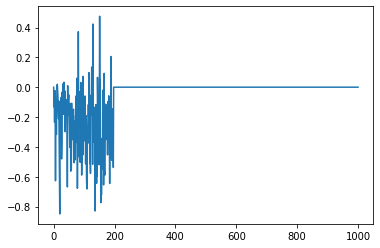

In [15]:
num_episode = 1
for episode in range(num_episode):
    pnl = np.array([])
    timestep = environment.reset()

    while not timestep.last():
        action = actor.select_action(timestep.observation)
        timestep = environment.step(action)
        pnl = np.append(pnl, timestep.reward)

    plt.plot(pnl)
    print('PnL Mean: %s' % str(np.mean(pnl)))
    print('PnL Std:  %s' % str(np.std(pnl)))

# D4PG

In [17]:
def make_networks(
    action_spec: types.NestedSpec,
    policy_layer_sizes: Sequence[int] = (10, 10),
    critic_layer_sizes: Sequence[int] = (10, 10),
    vmin: float = -150.,
    vmax: float = 150.,
    num_atoms: int = 51,
) -> Dict[str, snt.Module]:
  """Creates networks used by the agent."""

  num_dimensions = np.prod(action_spec.shape, dtype=int)
  policy_layer_sizes = list(policy_layer_sizes) + [num_dimensions]

  policy_network = snt.Sequential(
      [networks.LayerNormMLP(policy_layer_sizes), tf.tanh])
  critic_network = snt.Sequential([
      networks.CriticMultiplexer(
          critic_network=networks.LayerNormMLP(
              critic_layer_sizes, activate_final=True)),
      networks.DiscreteValuedHead(vmin, vmax, num_atoms)
  ])

  return {
      'policy': policy_network,
      'critic': critic_network,
  }

NameError: name 'types' is not defined

In [ ]:
spec = specs.make_environment_spec(environment)

# Create the networks.
agent_networks = make_networks(spec.actions)

# Construct the agent.
agent = d4pg.D4PG(
    environment_spec=spec,
    policy_network=agent_networks['policy'],
    critic_network=agent_networks['critic'],
    batch_size=10,
    samples_per_insert=2,
    min_replay_size=30,
)

# Try running the environment loop. We have no assertions here because all
# we care about is that the agent runs without raising any errors.
loop = acme.EnvironmentLoop(environment, agent)
loop.run(num_episodes=2)